# IUST Deep Learning - Final Project
## Single Image Super Resolution
### Taha Samavati - 98722134

In [ ]:
# imports
import tensorflow as tf
from tensorflow.keras.layers import Conv2D,BatchNormalization,PReLU,Add,Activation,Input,Lambda
from tensorflow.keras.models import Model,load_model,Sequential
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as preprocess_input_i3
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.python.data.experimental import AUTOTUNE
from numpy.random import shuffle
from scipy.linalg import sqrtm
from IPython.display import clear_output
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2,os

### download and create DIV2K dataset
**Code is obtained from:**  https://cutt.ly/3d7h239

In [ ]:
from dataset_loader import DIV2K

In [ ]:
train = DIV2K(scale=4, downgrade='bicubic', subset='train')
train_ds = train.dataset(batch_size=16, random_transform=True)

In [ ]:
div2k_valid = DIV2K(scale=4, subset='valid', downgrade='bicubic')
valid_ds = div2k_valid.dataset(batch_size=16, random_transform=True, repeat_count=1)

# Models

In [ ]:
def normalize(x):
    return x / 127.5 - 1

def denormalize(x):
    return (x + 1) * 127.5

def psnr(x1, x2):
    return tf.image.psnr(x1, x2, max_val=255)

def pixel_shuffle(scale):
    return lambda x: tf.nn.depth_to_space(x, scale)

In [ ]:
HR_SIZE=128
LR_SIZE=32

def upsample(x_in, num_filters):
    x = Conv2D(num_filters, kernel_size=3, padding='same')(x_in)
    x = Lambda(pixel_shuffle(scale=2))(x)
    return PReLU(shared_axes=[1, 2])(x)


def res_block(x_in, num_filters, block_num, momentum=0.8):
    x = Conv2D(num_filters, kernel_size=3, padding='same')(x_in)
    x = BatchNormalization(momentum=momentum)(x)
    x = PReLU(shared_axes=[1, 2])(x)
    x = Conv2D(num_filters, kernel_size=3, padding='same')(x)
    x = BatchNormalization(momentum=momentum)(x)
    x = x_in + x
    return x


def generator(num_filters=64, num_res_blocks=18):
    x_in = Input(shape=(None, None, 3))
    x = Lambda(normalize)(x_in)

    x = Conv2D(num_filters, kernel_size=9, padding='same')(x)
    x = x_1 = PReLU(shared_axes=[1, 2])(x)

    for _ in range(num_res_blocks):
        x = res_block(x, num_filters, _)

    x = Conv2D(num_filters, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = x_1 + x

    x = upsample(x, num_filters * 4)
    x = upsample(x, num_filters * 4)

    x = Conv2D(3, kernel_size=9, padding='same', activation='tanh')(x)
    x = Lambda(denormalize)(x)

    return Model(x_in, x)


def discriminator_block(x_in, num_filters, strides=1, batchnorm=True, momentum=0.8):
    x = Conv2D(num_filters, kernel_size=3, strides=strides, padding='same')(x_in)
    if batchnorm:
        x = BatchNormalization(momentum=momentum)(x)
    return tf.keras.layers.LeakyReLU(alpha=0.2)(x)


def original_descriminator(num_filters=64):
    x_in = Input(shape=(HR_SIZE, HR_SIZE, 3))
    x = Lambda(normalize)(x_in)

    x = discriminator_block(x, num_filters, batchnorm=False)
    x = discriminator_block(x, num_filters, strides=2)

    x = discriminator_block(x, num_filters * 2)
    x = discriminator_block(x, num_filters * 2, strides=2)

    x = discriminator_block(x, num_filters * 4)
    x = discriminator_block(x, num_filters * 4, strides=2)

    x = discriminator_block(x, num_filters * 8)
    x = discriminator_block(x, num_filters * 8, strides=2)

    x = tf.keras.layers.Flatten()(x)

    x = tf.keras.layers.Dense(1024)(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    return Model(x_in, x)

In [ ]:
def improved_discriminator(num_filters=48):
    x_in = Input(shape=(None, None, 3))
    x = Lambda(normalize)(x_in)

    x = discriminator_block(x, num_filters, batchnorm=False)
    x = discriminator_block(x, num_filters, strides=2)

    x = discriminator_block(x, num_filters * 2)
    x = discriminator_block(x, num_filters * 2, strides=2)

    x = discriminator_block(x, num_filters * 4)
    x = discriminator_block(x, num_filters * 4, strides=2)

    x = discriminator_block(x, num_filters * 8)
    x = discriminator_block(x, num_filters * 8, strides=2)

    x = tf.keras.layers.Conv2D(512, 3, strides=1)(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    
    x = tf.keras.layers.Conv2D(1, 6, strides=1)(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Activation('sigmoid')(x)

    return Model(x_in, x)

In [ ]:
def vgg(output_layer):
    vgg = VGG19(input_shape=(None, None, 3), include_top=False)
    return Model(vgg.input, vgg.layers[output_layer].output)

def vgg_54():
    return vgg(20)

In [ ]:
@tf.function
def content_loss(hr, sr):
    sr = preprocess_input(sr)
    hr = preprocess_input(hr)
    sr_features = vgg(sr) / 12.75
    hr_features = vgg(hr)/ 12.75
    return tf.reduce_mean(tf.square(hr_features - sr_features))
@tf.function
def generator_loss(sr_out):
    return binary_cross_entropy(tf.ones_like(sr_out), sr_out)
@tf.function
def dct_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(tf.signal.dct(y_true) - tf.signal.dct(y_pred)))
@tf.function
def discriminator_loss(hr_out, sr_out):
    hr_loss = binary_cross_entropy(tf.ones_like(hr_out), hr_out)
    sr_loss = binary_cross_entropy(tf.zeros_like(sr_out), sr_out)
    return hr_loss + sr_loss

In [ ]:
# construct vgg19 model for computing content loss
vgg = vgg_54()

# construct improved discriminator
generator = generator()

# FCN discriminator (improved)
discriminator = improved_discriminator()

In [ ]:
BATCH_SIZE = 16
INPUT_SCALE = 4

binary_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)
schedule = PiecewiseConstantDecay(boundaries=[200000], values=[1e-4, 1e-5])
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=schedule)
discriminator_optimizer =  tf.keras.optimizers.Adam(learning_rate=schedule)


@tf.function
def train_step(lr, hr):
    # training step.
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        lr = tf.cast(lr, tf.float32)
        hr = tf.cast(hr, tf.float32)

        # prediction stage
        sr = generator(lr, training=True)
        hr_output = discriminator(hr, training=True)
        sr_output = discriminator(sr, training=True)

        # Compute losses
        con_loss = content_loss(hr, sr)
        gen_loss = generator_loss(sr_output)
        dct_ls = dct_loss(hr, sr)
        
        gen_loss = con_loss + 0.001 * gen_loss + 0.001 * dct_ls

        disc_loss = discriminator_loss(hr_output, sr_output)

    # Compute gradient of perceptual loss for generator weights 
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    # Compute gradient of discriminator loss for discriminator weights 
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Update weights of generator and discriminator
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

# Pretrain generator with MSE loss

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=PiecewiseConstantDecay(boundaries=[100000], values=[1e-4, 5e-5]))
file_path='/kaggle/working/SRResNet_generator_tf_pretrained_improved.hdf5'
callbacks = [ModelCheckpoint(file_path, verbose=1, mode='auto',period=5)]

# Compile and pre train the model with just MSE loss
generator.compile(optimizer=optimizer, loss='mse')
generator.fit(train_ds, epochs=10, steps_per_epoch=800,callbacks=callbacks,validation_data=valid_ds.take(25))
generator.save_weights('/kaggle/working/SRResNet_generator_tf_pretrained_improved.hdf5')

# Full Adversarial training

In [ ]:
steps =20000
step = 0
generator_metric = tf.keras.metrics.Mean()
discriminator_metric = tf.keras.metrics.Mean()

# Adversarial training
for lr, hr in train_ds.take(steps):
    step += 1

    genLoss, discLoss = train_step(lr, hr)
    generator_metric(genLoss)
    discriminator_metric(discLoss)

    if step % 1000 == 0:
        print(f'{step}/{steps}, perceptual loss = {generator_metric.result():.4f}, discriminator loss = {discriminator_metric.result():.4f}')
        generator.save_weights('/kaggle/working/SRResNet_generator_tf_adversarial_improved.hdf5')
        discriminator.save_weights('/kaggle/working/SRResNet_discriminator_tf_adversarial_improved.hdf5')
        generator_metric.reset_states()
        discriminator_metric.reset_states()

# Evaluation
* **Evaluation of model performance on Benchmark datasets: Set 5, BSD100, URBAN100 and DIV2K Valid**

In [ ]:
discriminator.load_weights('/kaggle/input/srmodels/discriminator_tf_adversarial_improved.hdf5')
generator.load_weights('/kaggle/input/srmodels/generator_tf_adversarial_improved.hdf5')

In [ ]:
# Download datasets
!wget "http://vllab.ucmerced.edu/wlai24/LapSRN/results/SR_testing_datasets.zip" -O SR_testing_datasets.zip && unzip SR_testing_datasets.zip
clear_output()

In [ ]:
# function to evaluation and load preprocess data
def load_data(path):

    file_names = os.listdir(path)
    targets, inputs= [], []

    for i,file_n in enumerate(file_names):
        img = plt.imread(path+file_n) * 255.

        target = np.expand_dims(img, 0)
        target = tf.convert_to_tensor(target)
        target = tf.image.resize(target,(target.shape[1]-(target.shape[1]%4),target.shape[2]-(target.shape[2]%4)),method='bicubic')
        inp = tf.image.resize(np.expand_dims(img,0),(target.shape[1]//4,target.shape[2]//4),method='bicubic')

        inputs.append(inp)
        targets.append(target)

    return targets,inputs

In [ ]:
# Load evaluation datasets
targs5,inps5 = load_data('./Set5/')
targs_bsd,inps_bsd = load_data('./BSDS100/')
targs_urb,inps_urb = load_data('./Urban100/')

## Define Evaluation metrics

In [ ]:
@tf.function
def SSIM(y_true, y_pred):
    return tf.image.ssim(y_true,y_pred,max_val=255)
@tf.function
def PSNR(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=255)

In [ ]:
# calculate frechet inception distance
def FID(inp, trg):

    inp = preprocess_input_i3(inp)
    trg = preprocess_input_i3(trg)
    inp = tf.image.resize(inp, (299,299), tf.image.ResizeMethod.BICUBIC)
    trg = tf.image.resize(trg, (299,299), tf.image.ResizeMethod.BICUBIC)
    # calculate activation maps
    act1 = inception3(inp).numpy()
    act2 = inception3(trg).numpy()
    # calculate mean and covariance
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between covs
    covmean = sqrtm(sigma1.dot(sigma2))
    # correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    # calculate fid score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid
 
# prepare the inception v3 model
inception3 = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

# Results (Improved Model)

In [ ]:
generator.compile(optimizer='adam',loss='mse',metrics=[PSNR,SSIM,FID],run_eagerly=True)
generator.evaluate(valid_ds)

7/7 [==============================] - 95s 14s/step - loss: 210.5502 - PSNR: 29.5027 - SSIM: 0.7673 - calculate_fid: 281.5805


[210.5502471923828, 29.502696990966797, 0.7673081159591675, 281.58050537109375]

In [ ]:
generator.compile(optimizer='adam',loss='mse',metrics=[PSNR,SSIM])
results_set5 = generator.evaluate(inps5,targs5)
results_bsd = generator.evaluate(inps_bsd,targs_bsd)
results_urb = generator.evaluate(inps_urb,targs_urb)

1/1 [==============================] - 0s 2ms/step - loss: 1087.6360 - PSNR: 17.7660 - SSIM: 0.6270


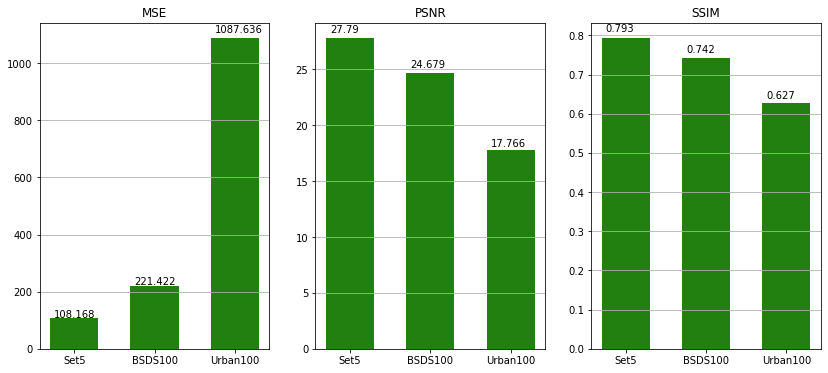

In [ ]:
overall_results=[results_set5,results_bsd,results_urb]
titles=['MSE','PSNR','SSIM']
plt.figure(figsize=(14,6))
plt.title("SR-GAN improved Evaluation")
for i in range(3):
  
  plt.subplot(1,3,i+1)
  plt.title(titles[i])
  plt.bar(['Set5','BSDS100','Urban100'],[overall_results[0][i],overall_results[1][i],overall_results[2][i]],width=0.6,color='#228010')
  plt.grid(axis='y')
  for j in range(3):
    plt.text(j-0.25,round(overall_results[j][i],3)+0.02*round(overall_results[j][i],3),round(overall_results[j][i],3))

plt.show()

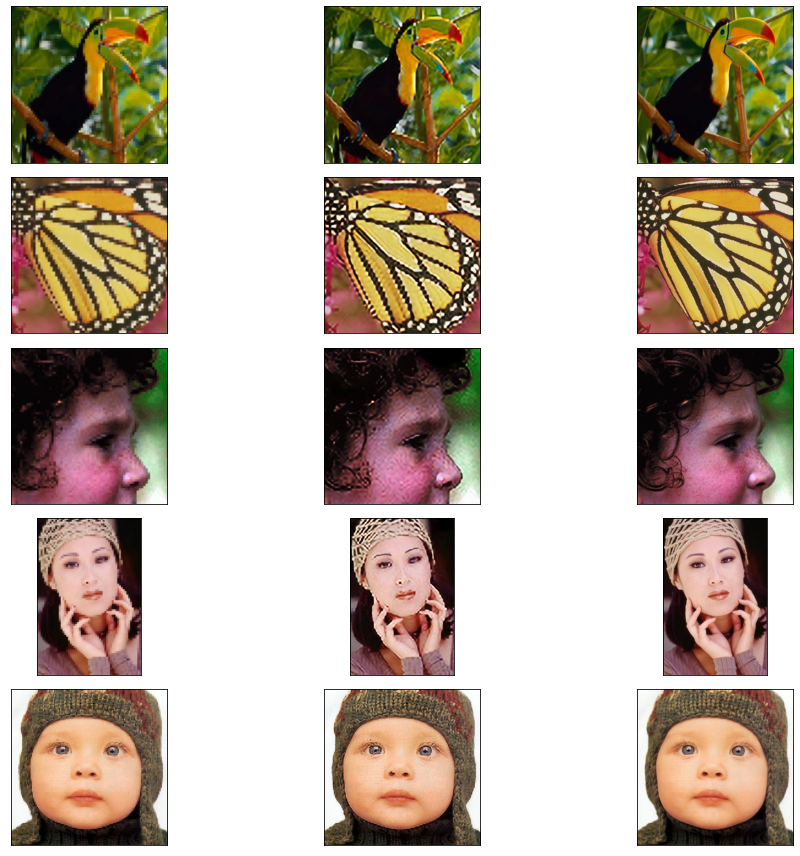

In [ ]:
def plot_results(inputs,targets, n=5):
    plt.figure(figsize=(15,12))
    if n==0:
        n = len(inputs)
    for i in range(n):
        plt.subplot(n,3,(3*i)+1)
        plt.imshow(tf.cast(inputs[i],tf.uint8)[0])
        plt.xticks([])
        plt.yticks([])
        plt.subplot(n,3,(3*i)+2)
        plt.imshow(tf.cast(generator.predict(inputs[i]),tf.uint8)[0])
        plt.xticks([])
        plt.yticks([])
        plt.subplot(n,3,(3*i)+3)
        plt.imshow(tf.cast(targets[i],tf.uint8)[0])
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show()

plot_results(inps5,targs5,0)

In [ ]:
valid_inp , valid_trg=[],[]
for inp, targ in valid_ds.take(5):
    valid_inp.append(inp.numpy())
    valid_trg.append(targ.numpy())
plot_results(valid_inp,valid_trg)

In [ ]:
plot_results(inps_bsd,targs_bsd,5)

# Results for Original implemented SRGAN model (baseline)

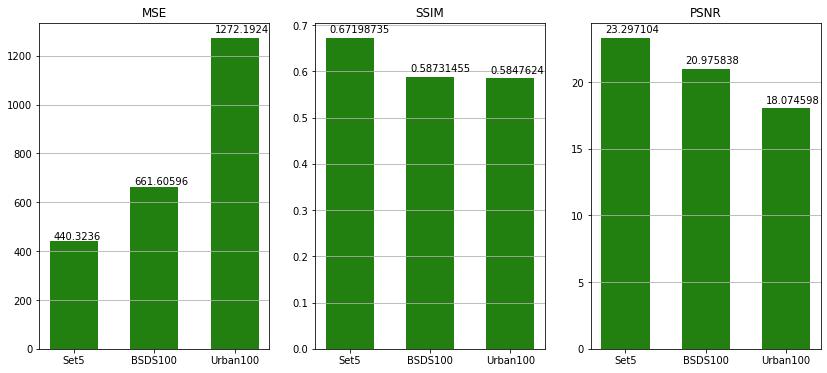

In [ ]:
overall_results=[results_set5,results_bsd,results_urb]
titles=['MSE','SSIM','PSNR']
plt.figure(figsize=(14,6))
plt.title("SR-GAN Evaluation")
for i in range(3):
  
  plt.subplot(1,3,i+1)
  plt.title(titles[i])
  plt.bar(['Set5','BSDS100','Urban100'],[overall_results[0][i],overall_results[1][i],overall_results[2][i]],width=0.6,color='#228010')
  plt.grid(axis='y')
  for j in range(3):
    plt.text(j-0.25,overall_results[j][i]+0.02*(overall_results[j][i]),overall_results[j][i])

plt.show()